In [408]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np

import pickle 
import time
from qiskit.circuit.library import iSwapGate

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from collections import defaultdict
import json


    
from matplotlib import colormaps
list(colormaps)
cmap = 'gist_heat'


In [409]:
J=1
nQ=7
n_qubits=3*nQ
sqrt_iSWAP = iSwapGate().power(1/2)

nShots = 100000 
dtFactor=0.2
nSteps=10

matter_defect = 11
f= 3

Obtaining noise profile

1. getting truth time evolution

In [410]:
evs_list02_truth = np.load("deconf_sim_f0.2_truth.npy")
evs_list3_truth = np.load("deconf_sim_f3_truth.npy")
evs_list5_truth = np.load("deconf_sim_f5_truth.npy")

In [411]:
def getChargeProb(evs_list):
    p_list = []
    for evs in evs_list:
        site_list = []
        for i in range(evs.shape[0]):
            if i%2 == 0:
                site_list.append(evs[i])
        
        p_list.append(1-np.array(site_list))
                
    return np.array(p_list)

In [412]:
p_02_truth = getChargeProb(evs_list02_truth)
p_3_truth = getChargeProb(evs_list3_truth)
p_5_truth = getChargeProb(evs_list5_truth)

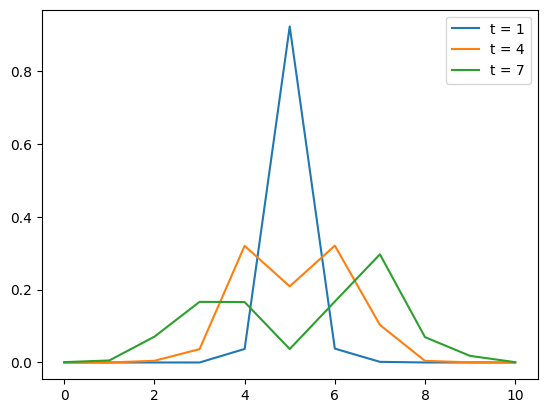

In [413]:
plt.plot(p_02_truth[1],label = 't = 1');
plt.plot(p_02_truth[4],label = 't = 4');
plt.plot(p_02_truth[7],label = 't = 7');
plt.legend()

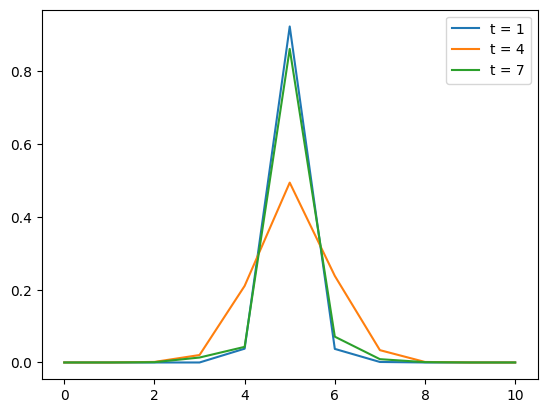

In [414]:
plt.plot(p_3_truth[1],label = 't = 1');
plt.plot(p_3_truth[4],label = 't = 4');
plt.plot(p_3_truth[7],label = 't = 7');
plt.legend()

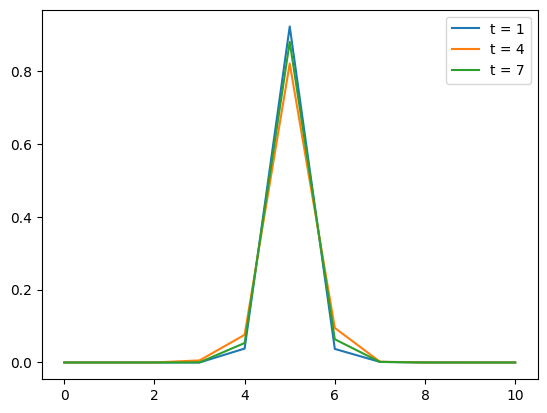

In [415]:
plt.plot(p_5_truth[1],label = 't = 1');
plt.plot(p_5_truth[4],label = 't = 4');
plt.plot(p_5_truth[7],label = 't = 7');
plt.legend()

Next, getting measurements on hardware

In [416]:
        
with open(f'stringList_{11}_{0.2}.json', 'r') as fin:
     string_list02 = json.load(fin)
with open(f'stringList_{11}_{3}.json', 'r') as fin:
     string_list3 = json.load(fin)
with open(f'stringList_{11}_{5}.json', 'r') as fin:
     string_list5 = json.load(fin)

In [417]:
def checkZ2Charge(key):
    charge = []
    firstCharge_pos = 0
    for i in np.arange(0,len(key),1): # Assuming first and last are matter site.
        #assuming matter sites are all even
        #it is backward!

        if i%2 == 0:
            charge.append(int(key[i]))
            if int(key[i]) == 0:
                firstCharge_pos = i 
            
    charge = np.array(charge)

    return charge.sum(),firstCharge_pos,charge
initial_charge = 10
initial_charge_position = n_qubits-matter_defect

initialKey = '101010101000101010101'
initialKey[initial_charge_position]
def getEVs(string,wiggleRoom = 0,initialKey = initialKey):
    out = np.zeros(n_qubits)
    shots = 0
    
    n_charge = []
    
    for key in list(string.keys()):
                
        
        charge, charge_position,charge_arr = checkZ2Charge(key)
        for j in range(string[key]):
            n_charge.append(charge - initial_charge)
        
        if abs(charge - initial_charge) > wiggleRoom:
            continue

        tmpKey = np.array([int(numeric_string) for numeric_string in initialKey])  

        if charge_position == initial_charge_position:
            tmpKey = tmpKey #do nothing

        else:
            tmpKey[initial_charge_position] = 1
            tmpKey[charge_position] = 0
            #then flip the links
            
            if charge_position > initial_charge_position:
                for pos in np.arange(initial_charge_position+1,charge_position,1):
                    if pos%2 ==1: #flip link
                        tmpKey[pos] = 1
                        
            else:
                for pos in np.arange(charge_position+1, initial_charge_position,1):
            
                    if pos%2 ==1: #flip link
                        tmpKey[pos] = 1
                  
  
        arr = 1 -2*tmpKey #|0> to have eigenValue of 1, and |1> to have -1.
        
        for i in range(arr.shape[0]): #introduce a negative sign for all the matter site
            if i%2==0:
                arr[i] = -arr[i]
        

        out += arr*string[key]
        shots += string[key]
    output = out/shots
    
    return (output+1)/2, np.array(n_charge)

In [418]:
evs_list3 = []

for string in string_list3:
    evs_list3.append(getEVs(string)[0])
    
evs_list3 = np.array(evs_list3)

evs_list02 = []

for string in string_list02:
    evs_list02.append(getEVs(string)[0])
    
evs_list02 = np.array(evs_list02)

evs_list5 = []

for string in string_list5:
    evs_list5.append(getEVs(string)[0])
    
evs_list5 = np.array(evs_list5)

In [419]:
p_02 = getChargeProb(evs_list02)
p_3 = getChargeProb(evs_list3)
p_5 = getChargeProb(evs_list5)

Fitting for the noise profile

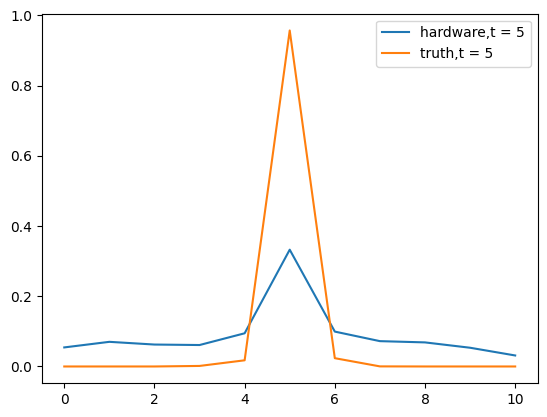

In [421]:
t = 5

plt.plot(p_5[t],label = f'hardware,t = {t}')
plt.plot(p_5_truth[t],label = f'truth,t = {t}')
plt.legend()

Getting the profile of the hardware noise

In [422]:
def convolute(p,window):
    nP = p.shape[0]
    half = int((nP+1)/2)-1
    center = half+1
    p_out = np.zeros(nP*2)

    for i in range(nP):
        tmp_p = p[i]
        tmp_window = tmp_p * window
        
        tmp_position = i+half
        p_out[tmp_position-half:tmp_position+half+1] += tmp_window  # the position of the +1 is actually very important
        
#     p_out[half+1] += p_out[0:half+1].sum()
#     p_out[-half] += p_out[-half:].sum()
    return p_out[half+1:-half]/p_out[half+1:-half].sum()

In [423]:
import scipy.optimize 

def compute_profile(profile,p_truth,p_obs):
    global cost_val_list
    conv = convolute(p_truth,profile)
    cost_val  = ((conv - p_obs)**(2)).sum() + 0.1*(profile.sum()-1)**2 
    cost_val_list.append(cost_val)
    return cost_val
    

In [424]:
profile_list = []
init_p = np.ones(11)/11

for t_index in range(evs_list02.shape[0]):

    cost_val_list=[]
    

    bds = []
    for i in range(init_p.shape[0]):
        bds.append((0,1))
    #init_p = p_3_truth[t_index]
    res = scipy.optimize.minimize(compute_profile,init_p,method='COBYLA',options={'maxiter':100000}
                                  ,args=(p_5_truth[t_index],p_5[t_index]),bounds = (bds) ) #minimize cost function via scipy

    profile=res.x
    
    profile_list.append(profile)
    init_p = profile
    
profile_list = np.array(profile_list)

/var/folders/9v/dz00k5396wl369lhxwggy12m0000gn/T/ipykernel_10519/4255950010.py:16: RuntimeWarning: divide by zero encountered in divide
  return p_out[half+1:-half]/p_out[half+1:-half].sum()
/var/folders/9v/dz00k5396wl369lhxwggy12m0000gn/T/ipykernel_10519/4255950010.py:16: RuntimeWarning: invalid value encountered in divide
  return p_out[half+1:-half]/p_out[half+1:-half].sum()


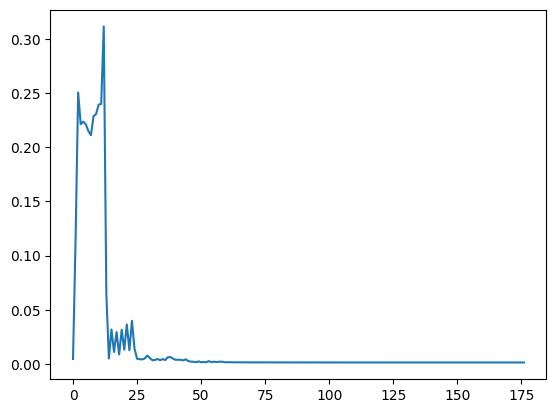

In [425]:
plt.plot(cost_val_list)

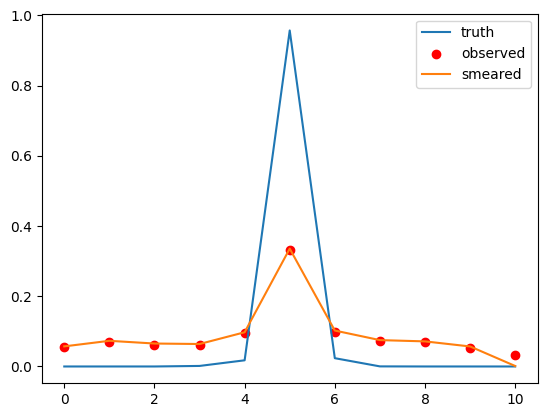

In [435]:
t_index = 5

plt.plot(p_5_truth[t_index],label='truth')
plt.scatter(range(p_5[t_index].shape[0]),p_5[t_index],color='r',label='observed')
plt.plot(convolute(profile_list[t_index],p_5_truth[t_index]),label='smeared')
plt.legend()

Testing the deconfinement case

In [427]:
def deconv_cost(p,profile,p_observed):
    global cost_val_list
    
    conv = convolute(p,profile)
    cost_val  = ((conv - p_observed)**(2)).sum() + 0.5*(p.sum()-1)**2 

    cost_val_list.append(cost_val)
    
    return cost_val

In [428]:
p_est_list = []

init_p = np.ones(11)/11

for i in range(p_02.shape[0]):
    
    
    bds = []
    for j in range(init_p.shape[0]):
        bds.append((0,1))

    #init_p = p_02_truth[i]

    res = scipy.optimize.minimize(deconv_cost,init_p,method='COBYLA',options={'maxiter':100000}
                                  ,args=(profile_list[i],p_02[i]),bounds = (bds) ) #minimize cost function via scipy
    p_est = res.x
    p_est_list.append(p_est)
    init_p = p_est
    #init_p = np.ones(11)/11
    
p_est_list = np.array(p_est_list)

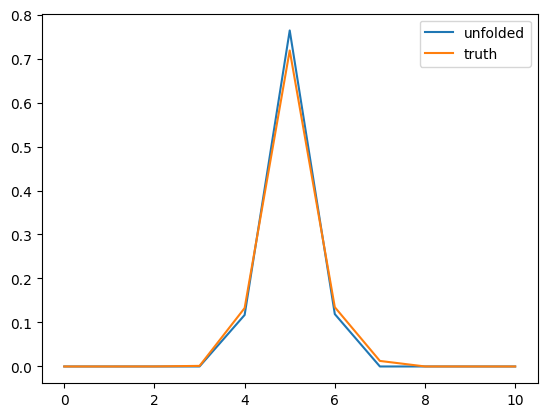

In [429]:
t_index = 2
plt.plot(p_est_list[t_index],label = 'unfolded')
plt.plot(p_02_truth[t_index],label = 'truth')
plt.legend()

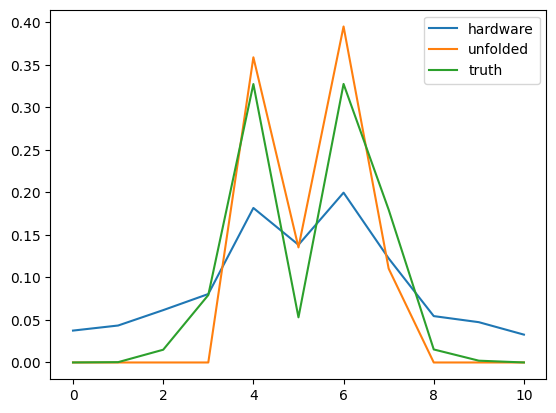

In [430]:
t_index = 5
plt.plot(p_02[t_index],label = 'hardware')
plt.plot(p_est_list[t_index],label = 'unfolded')
plt.plot(p_02_truth[t_index],label = 'truth')
plt.legend()

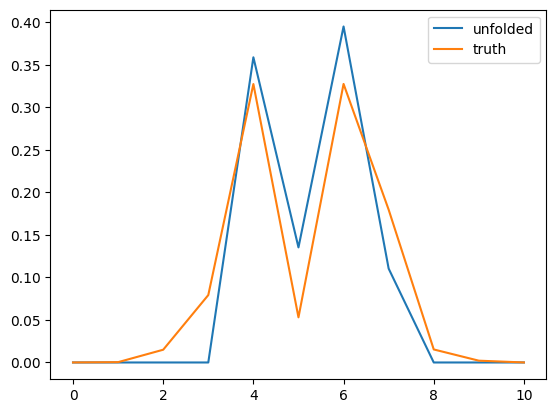

In [434]:
t_index = 5
plt.plot(p_est_list[t_index],label = 'unfolded')
plt.plot(p_02_truth[t_index],label = 'truth')
plt.legend()

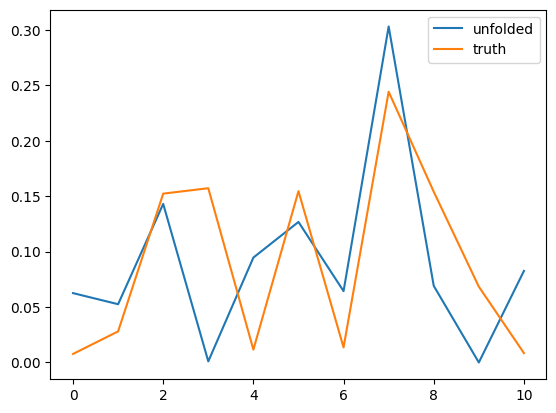

In [432]:
t_index = 9
plt.plot(p_est_list[t_index],label = 'unfolded')
plt.plot(p_02_truth[t_index],label = 'truth')
plt.legend()

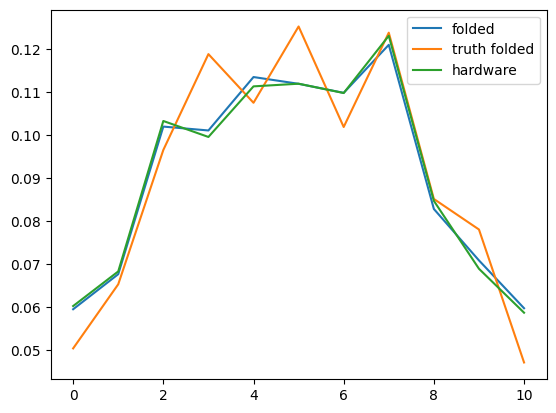

In [433]:
t_index = 9
plt.plot(convolute(profile_list[t_index],p_est_list[t_index]),label = 'folded')
plt.plot(convolute(profile_list[t_index],p_02_truth[t_index]),label = 'truth folded')
plt.plot(p_02[t_index],label = 'hardware')
plt.legend()

extrapolating profile

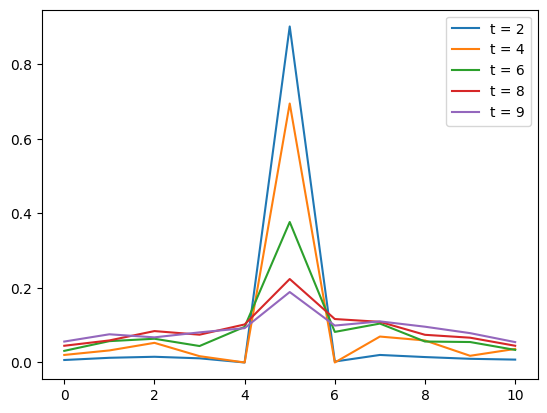

In [189]:
plt.plot(profile_list[2],label='t = 2')
plt.plot(profile_list[4],label='t = 4')
plt.plot(profile_list[6],label='t = 6')
plt.plot(profile_list[8],label='t = 8')
plt.plot(profile_list[9],label='t = 9')
plt.legend()

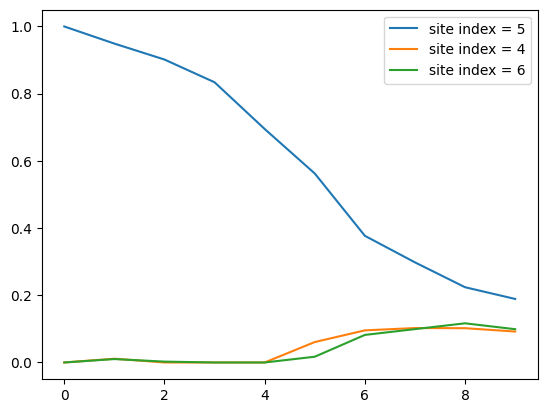

In [198]:
plt.plot(profile_list[:,5], label = 'site index = 5')
plt.plot(profile_list[:,4], label = 'site index = 4')
plt.plot(profile_list[:,6], label = 'site index = 6')

plt.legend()

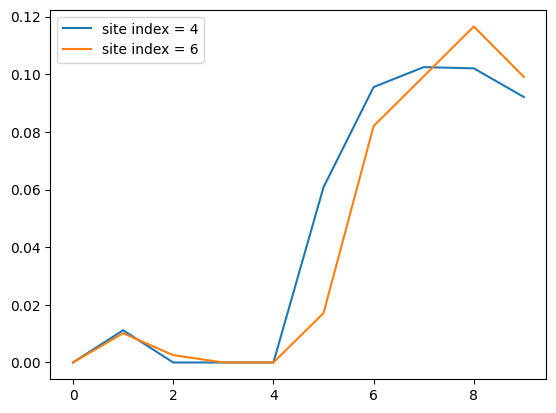

In [203]:
plt.plot(profile_list[:,4], label = 'site index = 4')
plt.plot(profile_list[:,6], label = 'site index = 6')

plt.legend()

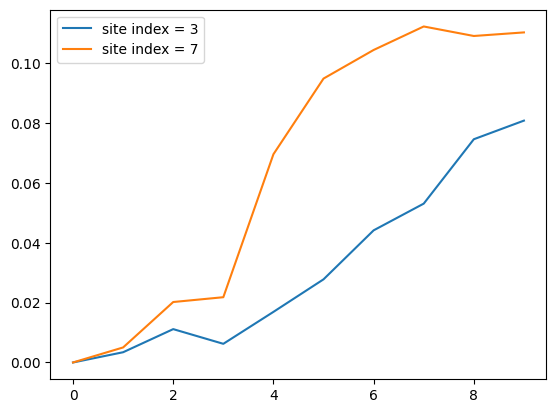

In [200]:

plt.plot(profile_list[:,3], label = 'site index = 3')
plt.plot(profile_list[:,7], label = 'site index = 7')
plt.legend()

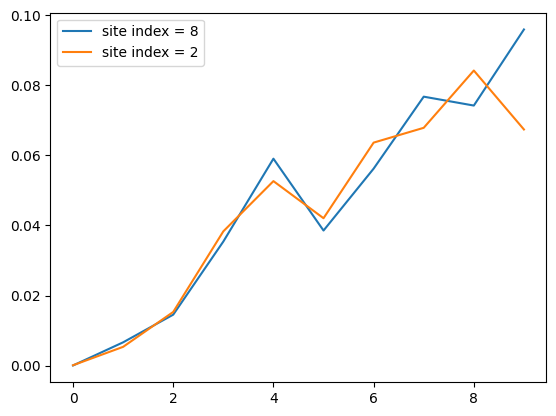

In [201]:

plt.plot(profile_list[:,8], label = 'site index = 8')
plt.plot(profile_list[:,2], label = 'site index = 2')
plt.legend()

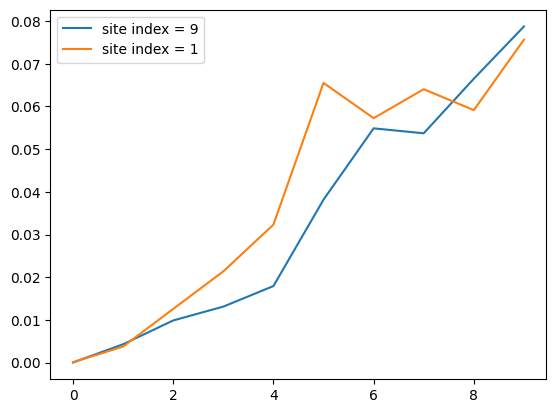

In [202]:

plt.plot(profile_list[:,9], label = 'site index = 9')
plt.plot(profile_list[:,1], label = 'site index = 1')
plt.legend()